<a href="https://colab.research.google.com/github/AndreaPardoGis/Machine.Learning/blob/main/transforms_tutorial_modificado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


.. redirect-from:: /tutorials/advanced/transforms_tutorial


# Transformations Tutorial

Like any graphics packages, Matplotlib is built on top of a transformation
framework to easily move between coordinate systems, the userland *data*
coordinate system, the *axes* coordinate system, the *figure* coordinate
system, and the *display* coordinate system.  In 95% of your plotting, you
won't need to think about this, as it happens under the hood, but as you push
the limits of custom figure generation, it helps to have an understanding of
these objects, so you can reuse the existing transformations Matplotlib makes
available to you, or create your own (see :mod:`matplotlib.transforms`).  The
table below summarizes some useful coordinate systems, a description of each
system, and the transformation object for going from each coordinate system to
the *display* coordinates.  In the "Transformation Object" column, ``ax`` is a
:class:`~matplotlib.axes.Axes` instance, ``fig`` is a
:class:`~matplotlib.figure.Figure` instance, and ``subfigure`` is a
:class:`~matplotlib.figure.SubFigure` instance.






```



+----------------+-----------------------------------+-----------------------------+
|Coordinate      |Description                        |Transformation object        |
|system          |                                   |from system to display       |
+================+===================================+=============================+
|"data"          |The coordinate system of the data  |``ax.transData``             |
|                |in the Axes.                       |                             |
+----------------+-----------------------------------+-----------------------------+
|"axes"          |The coordinate system of the       |``ax.transAxes``             |
|                |`~matplotlib.axes.Axes`; (0, 0)    |                             |
|                |is bottom left of the Axes, and    |                             |
|                |(1, 1) is top right of the Axes.   |                             |
+----------------+-----------------------------------+-----------------------------+
|"subfigure"     |The coordinate system of the       |``subfigure.transSubfigure`` |
|                |`.SubFigure`; (0, 0) is bottom left|                             |
|                |of the subfigure, and (1, 1) is top|                             |
|                |right of the subfigure.  If a      |                             |
|                |figure has no subfigures, this is  |                             |
|                |the same as ``transFigure``.       |                             |
+----------------+-----------------------------------+-----------------------------+
|"figure"        |The coordinate system of the       |``fig.transFigure``          |
|                |`.Figure`; (0, 0) is bottom left   |                             |
|                |of the figure, and (1, 1) is top   |                             |
|                |right of the figure.               |                             |
+----------------+-----------------------------------+-----------------------------+
|"figure-inches" |The coordinate system of the       |``fig.dpi_scale_trans``      |
|                |`.Figure` in inches; (0, 0) is     |                             |
|                |bottom left of the figure, and     |                             |
|                |(width, height) is the top right   |                             |
|                |of the figure in inches.           |                             |
+----------------+-----------------------------------+-----------------------------+
|"xaxis",        |Blended coordinate systems, using  |``ax.get_xaxis_transform()``,|
|"yaxis"         |data coordinates on one direction  |``ax.get_yaxis_transform()`` |
|                |and axes coordinates on the other. |                             |
+----------------+-----------------------------------+-----------------------------+
|"display"       |The native coordinate system of the|`None`, or                   |
|                |output ; (0, 0) is the bottom left |`.IdentityTransform()`       |
|                |of the window, and (width, height) |                             |
|                |is top right of the output in      |                             |
|                |"display units".                   |                             |
|                |                                   |                             |
|                |The exact interpretation of the    |                             |
|                |units depends on the back end. For |                             |
|                |example it is pixels for Agg and   |                             |
|                |points for svg/pdf.                |                             |
+----------------+-----------------------------------+-----------------------------+

```
The `~matplotlib.transforms.Transform` objects are naive to the source and
destination coordinate systems, however the objects referred to in the table
above are constructed to take inputs in their coordinate system, and transform
the input to the *display* coordinate system.  That is why the *display*
coordinate system has `None` for the "Transformation Object" column -- it
already is in *display* coordinates.  The naming and destination conventions
are an aid to keeping track of the available "standard" coordinate systems and
transforms.

The transformations also know how to invert themselves (via
`.Transform.inverted`) to generate a transform from output coordinate system
back to the input coordinate system.  For example, ``ax.transData`` converts
values in data coordinates to display coordinates and
``ax.transData.inverted()`` is a :class:`matplotlib.transforms.Transform` that
goes from display coordinates to data coordinates. This is particularly useful
when processing events from the user interface, which typically occur in
display space, and you want to know where the mouse click or key-press occurred
in your *data* coordinate system.

Note that specifying the position of Artists in *display* coordinates may
change their relative location if the ``dpi`` or size of the figure changes.
This can cause confusion when printing or changing screen resolution, because
the object can change location and size.  Therefore, it is most common for
artists placed in an Axes or figure to have their transform set to something
*other* than the `~.transforms.IdentityTransform()`; the default when an artist
is added to an Axes using `~.axes.Axes.add_artist` is for the transform to be
``ax.transData`` so that you can work and think in *data* coordinates and let
Matplotlib take care of the transformation to *display*.


## Data coordinates

Let's start with the most commonly used coordinate, the *data* coordinate
system.  Whenever you add data to the Axes, Matplotlib updates the datalimits,
most commonly updated with the :meth:`~matplotlib.axes.Axes.set_xlim` and
:meth:`~matplotlib.axes.Axes.set_ylim` methods.  For example, in the figure
below, the data limits stretch from 0 to 10 on the x-axis, and -1 to 1 on the
y-axis.


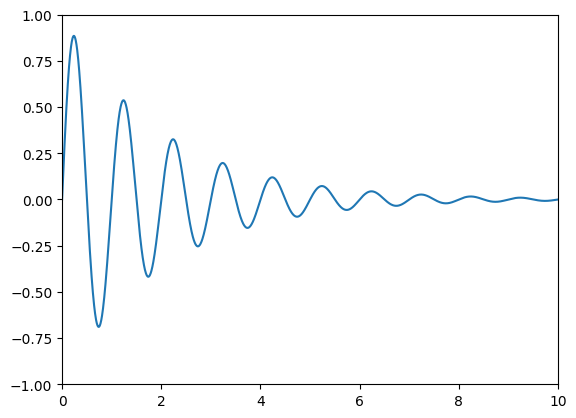

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.patches as mpatches

x = np.arange(0, 10, 0.005)
y = np.exp(-x/2.) * np.sin(2*np.pi*x)

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlim(0, 10)
ax.set_ylim(-1, 1)

plt.show()

You can use the ``ax.transData`` instance to transform from your
*data* to your *display* coordinate system, either a single point or a
sequence of points as shown below:

.. sourcecode:: ipython

    In [14]: type(ax.transData)
    Out[14]: <class 'matplotlib.transforms.CompositeGenericTransform'>

    In [15]: ax.transData.transform((5, 0))
    Out[15]: array([ 335.175,  247.   ])

    In [16]: ax.transData.transform([(5, 0), (1, 2)])
    Out[16]:
    array([[ 335.175,  247.   ],
           [ 132.435,  642.2  ]])

You can use the :meth:`~matplotlib.transforms.Transform.inverted`
method to create a transform which will take you from *display* to *data*
coordinates:

.. sourcecode:: ipython

    In [41]: inv = ax.transData.inverted()

    In [42]: type(inv)
    Out[42]: <class 'matplotlib.transforms.CompositeGenericTransform'>

    In [43]: inv.transform((335.175,  247.))
    Out[43]: array([ 5.,  0.])

If your are typing along with this tutorial, the exact values of the
*display* coordinates may differ if you have a different window size or
dpi setting.  Likewise, in the figure below, the display labeled
points are probably not the same as in the ipython session because the
documentation figure size defaults are different.



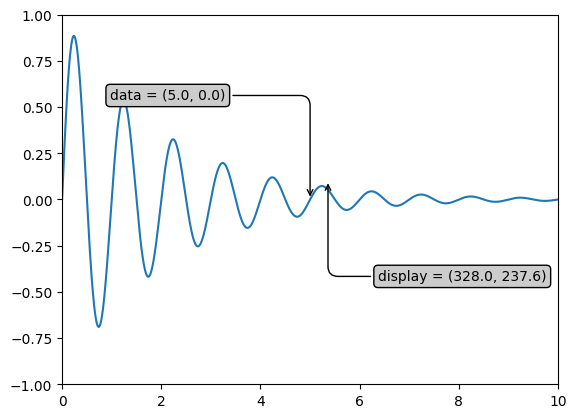

In [2]:
x = np.arange(0, 10, 0.005)
y = np.exp(-x/2.) * np.sin(2*np.pi*x)

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlim(0, 10)
ax.set_ylim(-1, 1)

xdata, ydata = 5, 0
# This computing the transform now, if anything
# (figure size, dpi, axes placement, data limits, scales..)
# changes re-calling transform will get a different value.
xdisplay, ydisplay = ax.transData.transform((xdata, ydata))

bbox = dict(boxstyle="round", fc="0.8")
arrowprops = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=90,rad=10")

offset = 72
ax.annotate(f'data = ({xdata:.1f}, {ydata:.1f})',
            (xdata, ydata), xytext=(-2*offset, offset), textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)

disp = ax.annotate(f'display = ({xdisplay:.1f}, {ydisplay:.1f})',
                   (xdisplay, ydisplay), xytext=(0.5*offset, -offset),
                   xycoords='figure pixels',
                   textcoords='offset points',
                   bbox=bbox, arrowprops=arrowprops)

plt.show()

<div class="alert alert-danger"><h4>Warning</h4><p>If you run the source code in the example above in a GUI backend,
  you may also find that the two arrows for the *data* and *display*
  annotations do not point to exactly the same point.  This is because
  the display point was computed before the figure was displayed, and
  the GUI backend may slightly resize the figure when it is created.
  The effect is more pronounced if you resize the figure yourself.
  This is one good reason why you rarely want to work in *display*
  space, but you can connect to the ``'on_draw'``
  :class:`~matplotlib.backend_bases.Event` to update *figure*
  coordinates on figure draws; see `event-handling`.</p></div>

When you change the x or y limits of your axes, the data limits are
updated so the transformation yields a new display point.  Note that
when we just change the ylim, only the y-display coordinate is
altered, and when we change the xlim too, both are altered.  More on
this later when we talk about the
:class:`~matplotlib.transforms.Bbox`.

.. sourcecode:: ipython

    In [54]: ax.transData.transform((5, 0))
    Out[54]: array([ 335.175,  247.   ])

    In [55]: ax.set_ylim(-1, 2)
    Out[55]: (-1, 2)

    In [56]: ax.transData.transform((5, 0))
    Out[56]: array([ 335.175     ,  181.13333333])

    In [57]: ax.set_xlim(10, 20)
    Out[57]: (10, 20)

    In [58]: ax.transData.transform((5, 0))
    Out[58]: array([-171.675     ,  181.13333333])



## Axes coordinates

After the *data* coordinate system, *axes* is probably the second most
useful coordinate system.  Here the point (0, 0) is the bottom left of
your Axes or subplot, (0.5, 0.5) is the center, and (1.0, 1.0) is the top
right.  You can also refer to points outside the range, so (-0.1, 1.1)
is to the left and above your Axes.  This coordinate system is extremely
useful when placing text in your Axes, because you often want a text bubble
in a fixed, location, e.g., the upper left of the Axes pane, and have that
location remain fixed when you pan or zoom.  Here is a simple example that
creates four panels and labels them 'A', 'B', 'C', 'D' as you often see in
journals.  A more sophisticated approach for such labeling is presented at
:doc:`/gallery/text_labels_and_annotations/label_subplots`.



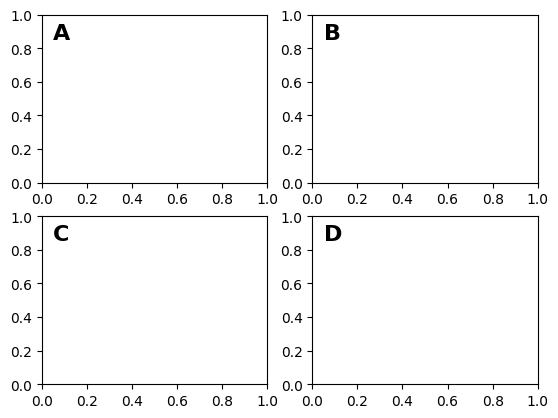

In [3]:
fig = plt.figure()
for i, label in enumerate(('A', 'B', 'C', 'D')):
    ax = fig.add_subplot(2, 2, i+1)
    ax.text(0.05, 0.95, label, transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top')

plt.show()

You can also make lines or patches in the *axes* coordinate system, but
this is less useful in my experience than using ``ax.transAxes`` for
placing text.  Nonetheless, here is a silly example which plots some
random dots in data space, and overlays a semi-transparent
:class:`~matplotlib.patches.Circle` centered in the middle of the Axes
with a radius one quarter of the Axes -- if your Axes does not
preserve aspect ratio (see :meth:`~matplotlib.axes.Axes.set_aspect`),
this will look like an ellipse.  Use the pan/zoom tool to move around,
or manually change the data xlim and ylim, and you will see the data
move, but the circle will remain fixed because it is not in *data*
coordinates and will always remain at the center of the Axes.



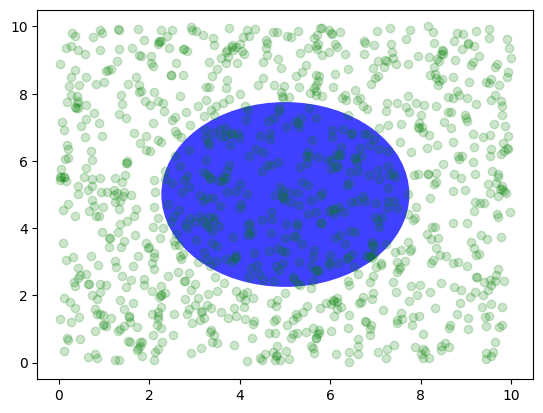

In [4]:
fig, ax = plt.subplots()
x, y = 10*np.random.rand(2, 1000)
ax.plot(x, y, 'go', alpha=0.2)  # plot some data in data coordinates

circ = mpatches.Circle((0.5, 0.5), 0.25, transform=ax.transAxes,
                       facecolor='blue', alpha=0.75)
ax.add_patch(circ)
plt.show()


## Blended transformations

Drawing in *blended* coordinate spaces which mix *axes* with *data*
coordinates is extremely useful, for example to create a horizontal
span which highlights some region of the y-data but spans across the
x-axis regardless of the data limits, pan or zoom level, etc.  In fact
these blended lines and spans are so useful, we have built-in
functions to make them easy to plot (see
:meth:`~matplotlib.axes.Axes.axhline`,
:meth:`~matplotlib.axes.Axes.axvline`,
:meth:`~matplotlib.axes.Axes.axhspan`,
:meth:`~matplotlib.axes.Axes.axvspan`) but for didactic purposes we
will implement the horizontal span here using a blended
transformation.  This trick only works for separable transformations,
like you see in normal Cartesian coordinate systems, but not on
inseparable transformations like the
:class:`~matplotlib.projections.polar.PolarAxes.PolarTransform`.



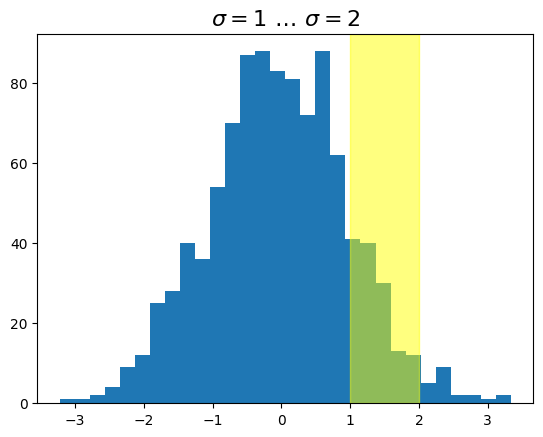

In [5]:
import matplotlib.transforms as transforms

fig, ax = plt.subplots()
x = np.random.randn(1000)

ax.hist(x, 30)
ax.set_title(r'$\sigma=1 \/ \dots \/ \sigma=2$', fontsize=16)

# the x coords of this transformation are data, and the y coord are axes
trans = transforms.blended_transform_factory(
    ax.transData, ax.transAxes)
# highlight the 1..2 stddev region with a span.
# We want x to be in data coordinates and y to span from 0..1 in axes coords.
rect = mpatches.Rectangle((1, 0), width=1, height=1, transform=trans,
                          color='yellow', alpha=0.5)
ax.add_patch(rect)

plt.show()

<div class="alert alert-info"><h4>Note</h4><p>The blended transformations where x is in *data* coords and y in *axes*
  coordinates is so useful that we have helper methods to return the
  versions Matplotlib uses internally for drawing ticks, ticklabels, etc.
  The methods are :meth:`matplotlib.axes.Axes.get_xaxis_transform` and
  :meth:`matplotlib.axes.Axes.get_yaxis_transform`.  So in the example
  above, the call to
  :meth:`~matplotlib.transforms.blended_transform_factory` can be
  replaced by ``get_xaxis_transform``::

    trans = ax.get_xaxis_transform()</p></div>


## Plotting in physical coordinates

Sometimes we want an object to be a certain physical size on the plot.
Here we draw the same circle as above, but in physical coordinates.  If done
interactively, you can see that changing the size of the figure does
not change the offset of the circle from the lower-left corner,
does not change its size, and the circle remains a circle regardless of
the aspect ratio of the Axes.



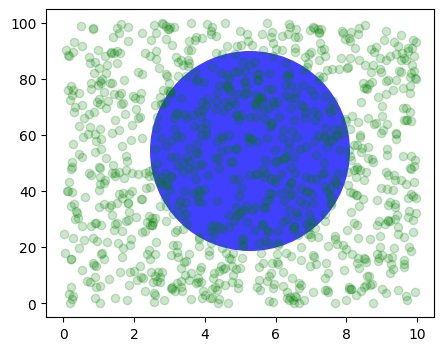

In [6]:
fig, ax = plt.subplots(figsize=(5, 4))
x, y = 10*np.random.rand(2, 1000)
ax.plot(x, y*10., 'go', alpha=0.2)  # plot some data in data coordinates
# add a circle in fixed-coordinates
circ = mpatches.Circle((2.5, 2), 1.0, transform=fig.dpi_scale_trans,
                       facecolor='blue', alpha=0.75)
ax.add_patch(circ)
plt.show()

If we change the figure size, the circle does not change its absolute
position and is cropped.



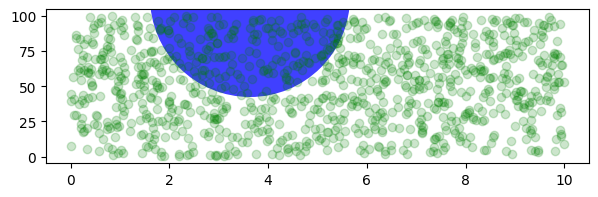

In [7]:
fig, ax = plt.subplots(figsize=(7, 2))
x, y = 10*np.random.rand(2, 1000)
ax.plot(x, y*10., 'go', alpha=0.2)  # plot some data in data coordinates
# add a circle in fixed-coordinates
circ = mpatches.Circle((2.5, 2), 1.0, transform=fig.dpi_scale_trans,
                       facecolor='blue', alpha=0.75)
ax.add_patch(circ)
plt.show()

Another use is putting a patch with a set physical dimension around a
data point on the Axes.  Here we add together two transforms.  The
first sets the scaling of how large the ellipse should be and the second
sets its position.  The ellipse is then placed at the origin, and then
we use the helper transform :class:`~matplotlib.transforms.ScaledTranslation`
to move it
to the right place in the ``ax.transData`` coordinate system.
This helper is instantiated with::

  trans = ScaledTranslation(xt, yt, scale_trans)

where *xt* and *yt* are the translation offsets, and *scale_trans* is
a transformation which scales *xt* and *yt* at transformation time
before applying the offsets.

Note the use of the plus operator on the transforms below.
This code says: first apply the scale transformation ``fig.dpi_scale_trans``
to make the ellipse the proper size, but still centered at (0, 0),
and then translate the data to ``xdata[0]`` and ``ydata[0]`` in data space.

In interactive use, the ellipse stays the same size even if the
axes limits are changed via zoom.




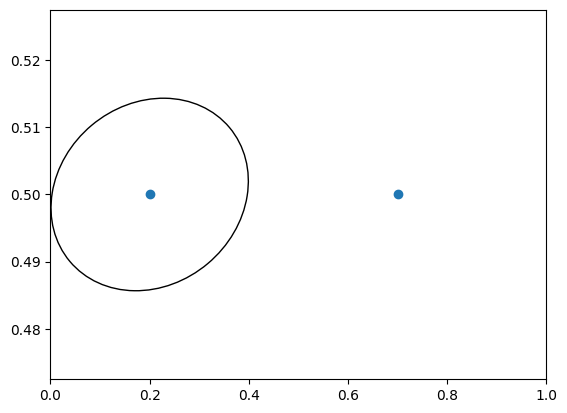

In [8]:
fig, ax = plt.subplots()
xdata, ydata = (0.2, 0.7), (0.5, 0.5)
ax.plot(xdata, ydata, "o")
ax.set_xlim((0, 1))

trans = (fig.dpi_scale_trans +
         transforms.ScaledTranslation(xdata[0], ydata[0], ax.transData))

# plot an ellipse around the point that is 150 x 130 points in diameter...
circle = mpatches.Ellipse((0, 0), 150/72, 130/72, angle=40,
                          fill=None, transform=trans)
ax.add_patch(circle)
plt.show()

<div class="alert alert-info"><h4>Note</h4><p>The order of transformation matters.  Here the ellipse
  is given the right dimensions in display space *first* and then moved
  in data space to the correct spot.
  If we had done the ``ScaledTranslation`` first, then
  ``xdata[0]`` and ``ydata[0]`` would
  first be transformed to *display* coordinates (``[ 358.4  475.2]`` on
  a 200-dpi monitor) and then those coordinates
  would be scaled by ``fig.dpi_scale_trans`` pushing the center of
  the ellipse well off the screen (i.e. ``[ 71680.  95040.]``).</p></div>


## Using offset transforms to create a shadow effect

Another use of :class:`~matplotlib.transforms.ScaledTranslation` is to create
a new transformation that is
offset from another transformation, e.g., to place one object shifted a
bit relative to another object.  Typically, you want the shift to be in
some physical dimension, like points or inches rather than in *data*
coordinates, so that the shift effect is constant at different zoom
levels and dpi settings.

One use for an offset is to create a shadow effect, where you draw one
object identical to the first just to the right of it, and just below
it, adjusting the zorder to make sure the shadow is drawn first and
then the object it is shadowing above it.

Here we apply the transforms in the *opposite* order to the use of
:class:`~matplotlib.transforms.ScaledTranslation` above. The plot is
first made in data coordinates (``ax.transData``) and then shifted by
``dx`` and ``dy`` points using ``fig.dpi_scale_trans``.  (In typography,
a [point](https://en.wikipedia.org/wiki/Point_%28typography%29) is
1/72 inches, and by specifying your offsets in points, your figure
will look the same regardless of the dpi resolution it is saved in.)



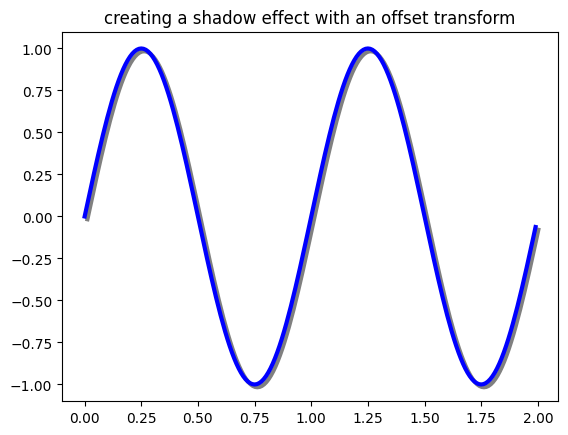

In [9]:
fig, ax = plt.subplots()

# make a simple sine wave
x = np.arange(0., 2., 0.01)
y = np.sin(2*np.pi*x)
line, = ax.plot(x, y, lw=3, color='blue')

# shift the object over 2 points, and down 2 points
dx, dy = 2/72., -2/72.
offset = transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
shadow_transform = ax.transData + offset

# now plot the same data with our offset transform;
# use the zorder to make sure we are below the line
ax.plot(x, y, lw=3, color='gray',
        transform=shadow_transform,
        zorder=0.5*line.get_zorder())

ax.set_title('creating a shadow effect with an offset transform')
plt.show()

<div class="alert alert-info"><h4>Note</h4><p>The dpi and inches offset is a
  common-enough use case that we have a special helper function to
  create it in :func:`matplotlib.transforms.offset_copy`, which returns
  a new transform with an added offset. So above we could have done::

     shadow_transform = transforms.offset_copy(ax.transData,
              fig, dx, dy, units='inches')</p></div>



## The transformation pipeline

The ``ax.transData`` transform we have been working with in this
tutorial is a composite of three different transformations that
comprise the transformation pipeline from *data* -> *display*
coordinates.  Michael Droettboom implemented the transformations
framework, taking care to provide a clean API that segregated the
nonlinear projections and scales that happen in polar and logarithmic
plots, from the linear affine transformations that happen when you pan
and zoom.  There is an efficiency here, because you can pan and zoom
in your Axes which affects the affine transformation, but you may not
need to compute the potentially expensive nonlinear scales or
projections on simple navigation events.  It is also possible to
multiply affine transformation matrices together, and then apply them
to coordinates in one step.  This is not true of all possible
transformations.


Here is how the ``ax.transData`` instance is defined in the basic
separable axis :class:`~matplotlib.axes.Axes` class::

  self.transData = self.transScale + (self.transLimits + self.transAxes)

We've been introduced to the ``transAxes`` instance above in
`axes-coords`, which maps the (0, 0), (1, 1) corners of the
Axes or subplot bounding box to *display* space, so let's look at
these other two pieces.

``self.transLimits`` is the transformation that takes you from
*data* to *axes* coordinates; i.e., it maps your view xlim and ylim
to the unit space of the Axes (and ``transAxes`` then takes that unit
space to display space).  We can see this in action here

.. sourcecode:: ipython

    In [80]: ax = plt.subplot()

    In [81]: ax.set_xlim(0, 10)
    Out[81]: (0, 10)

    In [82]: ax.set_ylim(-1, 1)
    Out[82]: (-1, 1)

    In [84]: ax.transLimits.transform((0, -1))
    Out[84]: array([ 0.,  0.])

    In [85]: ax.transLimits.transform((10, -1))
    Out[85]: array([ 1.,  0.])

    In [86]: ax.transLimits.transform((10, 1))
    Out[86]: array([ 1.,  1.])

    In [87]: ax.transLimits.transform((5, 0))
    Out[87]: array([ 0.5,  0.5])

and we can use this same inverted transformation to go from the unit
*axes* coordinates back to *data* coordinates.

.. sourcecode:: ipython

    In [90]: inv.transform((0.25, 0.25))
    Out[90]: array([ 2.5, -0.5])

The final piece is the ``self.transScale`` attribute, which is
responsible for the optional non-linear scaling of the data, e.g., for
logarithmic axes.  When an Axes is initially setup, this is just set to
the identity transform, since the basic Matplotlib axes has linear
scale, but when you call a logarithmic scaling function like
:meth:`~matplotlib.axes.Axes.semilogx` or explicitly set the scale to
logarithmic with :meth:`~matplotlib.axes.Axes.set_xscale`, then the
``ax.transScale`` attribute is set to handle the nonlinear projection.
The scales transforms are properties of the respective ``xaxis`` and
``yaxis`` :class:`~matplotlib.axis.Axis` instances.  For example, when
you call ``ax.set_xscale('log')``, the xaxis updates its scale to a
:class:`matplotlib.scale.LogScale` instance.

For non-separable axes the PolarAxes, there is one more piece to
consider, the projection transformation.  The ``transData``
:class:`matplotlib.projections.polar.PolarAxes` is similar to that for
the typical separable matplotlib Axes, with one additional piece
``transProjection``::

       self.transData = (
           self.transScale + self.transShift + self.transProjection +
           (self.transProjectionAffine + self.transWedge + self.transAxes))

``transProjection`` handles the projection from the space,
e.g., latitude and longitude for map data, or radius and theta for polar
data, to a separable Cartesian coordinate system.  There are several
projection examples in the :mod:`matplotlib.projections` package, and the
best way to learn more is to open the source for those packages and
see how to make your own, since Matplotlib supports extensible axes
and projections.  Michael Droettboom has provided a nice tutorial
example of creating a Hammer projection axes; see
:doc:`/gallery/misc/custom_projection`.



In [10]:
# Importamos la biblioteca que nos falta y no esta importada en este doc
from matplotlib.transforms import Affine2D

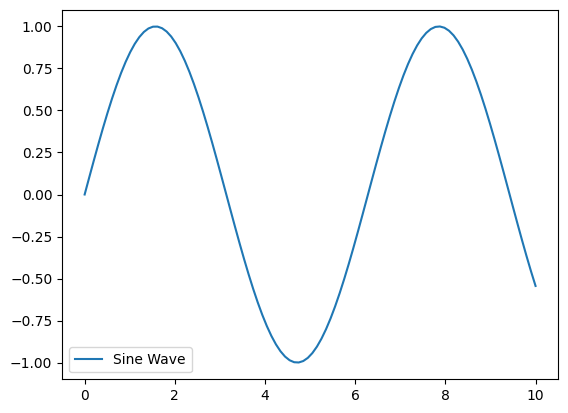

In [11]:
# Empezare creando un grafico simple.
# Esto nos ayuda a tener una base sobre la cual aplicar las transformaciones
x = np.linspace(0, 10, 100)
y = np.sin(x)

fig, ax = plt.subplots()
ax.plot(x, y, label = "Sine Wave")
ax.legend()
plt.show()

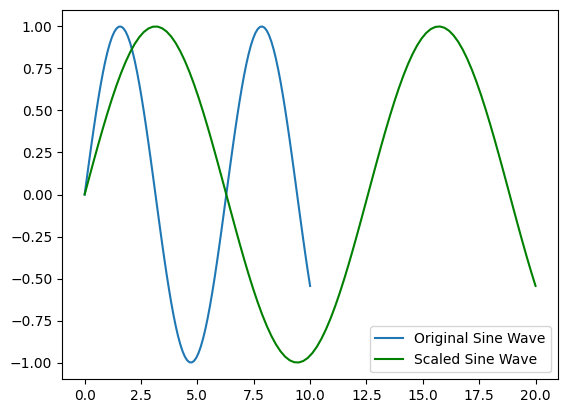

In [20]:
# Aqui voy a aplicar una transformacion de escala en los datos para
# cambiar como se visualiza

fig, ax = plt.subplots()
ax.plot(x, y, label = "Original Sine Wave")

# Se crea la transformacion de escala
trans = Affine2D().scale(2, 1) + ax.transData

# Se aplica
ax.plot(x, y, transform = trans, label = "Scaled Sine Wave", color = "green")

# Se agrega la leyenda y se muestra el grafico
ax.legend()
plt.show()

In [21]:
# Las transformaciones son utiles para anotar elementos en el grafico.
# Aqui hare una anotacion en una posicion relativa a las coordenadas del grafico
ax.annotate("Annotated Point", xy = (5, np.sin(5)), xytext = (7, 0.5),
            arrowprops = dict(facecolor = "black", shrink = 0.5),
            transform = ax.transData)

# xy define las coordenadas del punto que queremos anotar,
# y xytext es la posición del texto de la anotación.

Text(7, 0.5, 'Annotated Point')

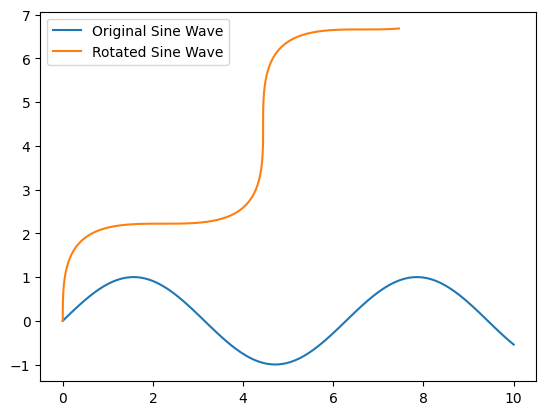

In [23]:
# Rotare el grafico
x = np.linspace(0, 10, 100)
y = np.sin(x)

fig, ax= plt.subplots()
ax.plot(x, y, label = "Original Sine Wave")

# Se crea la transformacion de la rotacion
trans_rotate = Affine2D().rotate_deg(45) + ax.transData

# Se aplica la transformacion
ax.plot(x, y, transform = trans_rotate, label = "Rotated Sine Wave")
# Se agrega leyenda y se muestra el grafico
ax.legend()
plt.show()

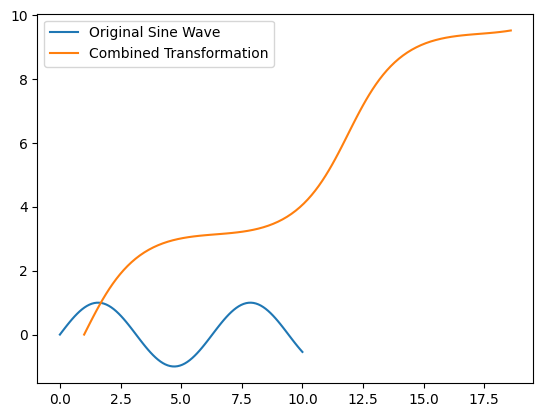

In [28]:
# Voy a combinar escalas, translaciones y rotaciones
x = np.linspace(0, 10, 100)
y = np.sin(x)

fig, ax= plt.subplots()
ax.plot(x, y, label = "Original Sine Wave")


combined_trans = Affine2D().scale(2, 1).rotate_deg(30).translate(1, 0) + ax.transData
ax.plot (x, y, transform = combined_trans, label = "Combined Transformation")
ax.legend()
plt.show()

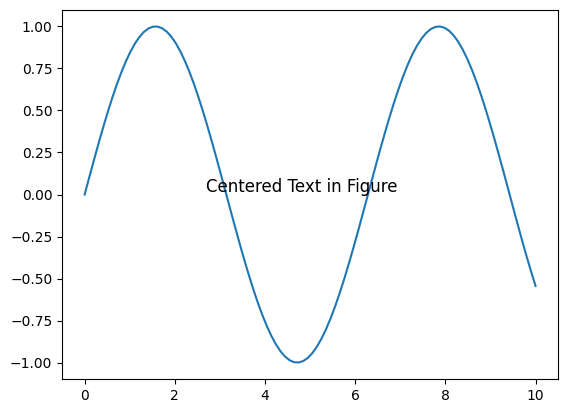

In [32]:
# Usare coordenadas de figura.
# Posicionare el elemento texto en la ventana
# usando transformaciones de coordenadas de figura (transfigure)
# Esto es util para crear anotaciones fuera del area de datos.
x = np.linspace(0, 10, 100)
y = np.sin(x)

fig, ax= plt.subplots()
ax.plot(x, y, label = "Original Sine Wave")


ax.text(0.5, 0.5, "Centered Text in Figure",
        transform = fig.transFigure, fontsize = 12, ha = "center")
plt.show()